# DSB analysis with Python
Python as a high-level language can be used as an alternative for existing software packages and/or plugins/macros for DNA double strand break analysis. Combined with the image processing library *scikit-image*, it is easily possible to write customized scripts fitted for the specific needs of the researcher. The following python code will show exemplary a rough approach on how to tackle nucleus and signal detection in fluorescence images.

At first, following modules have to be implemented:

In [1]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from skimage.filters import threshold_minimum
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Thereby, *skimage.io* is a module that ontains "*Utilities to read and write images in various formats.*". It will be used to load the example image. *matplotlib.pyplot* is a mighty package that can be used for various plotting tasks. In this example, it will be used to show the images of various processing steps. *numpy* is one of the most used python packages for scientific computing, which will be used for the array representation of the loaded images. The other imports will be explaned when they arrive later.

After importing the necessary modules, the first thing to do is to load the image:

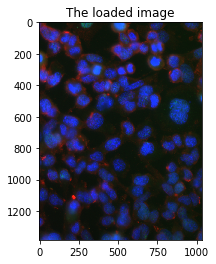

In [2]:
# Load the image
img = io.imread("test1.png")
# Show the loaded image
plt.imshow(img)
plt.title("The loaded image")
plt.show()

The next step is to isolate the color channels from the loaded image. This is necessary to separate the nuclei signal from the two foci signals:

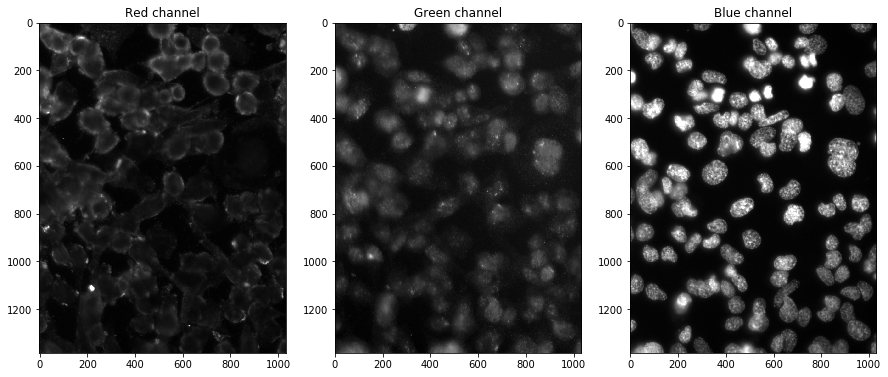

In [3]:
'''
img was loaded as a numpy array in the format x, y [R,G,B].
The individual channels can be isolated via so called list-slicing, which means a new list is created from elements
of an already existing list. Thereby, an element has to suffice given conditions to be copied into the new list.
The structure of the command is the following: [startIndex:stopIndex]. This will create a list of all elements of the 
given list which have an index between startIndex and stopIndex-1. If no indices are given, all elements will be copied
to the new list. If a one number is given, only the element which the given index is copied.
'''
red = img[:, :, 0]
# The green and blue channel will be isolated like the red channel
green = img[:, :, 1]
blue = img[:, :, 2]
#Show the isolated channels
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 7))
ax = axes.ravel()
ax[0].imshow(red, cmap='gray')
ax[0].set_title("Red channel")
ax[1].imshow(green, cmap='gray')
ax[1].set_title("Green channel")
ax[2].imshow(blue, cmap='gray')
ax[2].set_title("Blue channel")
plt.show()

After isolation of the respective color channels, each individual nucleus has to be isolated. At first, the channel image has to be binarized to allow follow-up processing operations. Several automatic approaches for image binarization (also referred to as theresholding) exist such as otsu's or yen's thresholding method. Here we will use the minimum method, which we imported via the import *from skimage.filters import threshold_minimum*:

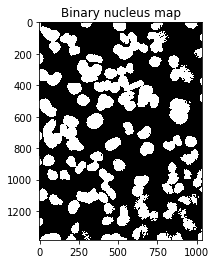

In [4]:
# At first, the individual thresholds for each pixel of the channel have to be calculated
thresholds = threshold_minimum(blue)
# Then the thresholded image has to be created
nuc_map = blue > thresholds
# Show the created binary map of the nuclei. The white area marks the identified nuclei
plt.imshow(nuc_map, cmap='gray')
plt.title("Binary nucleus map")
plt.show()

The created nucleus map now needs to be further processed to separate overlapping nuclei. The first thing for segmentation is the calculation of the *euclidean distance map* (EDM). The EDM will calculate the distance of each pixel to the nearest border pixel of its area. This allows it to estimate the center of each individual nucleus of inside the overlapping nucleus area.

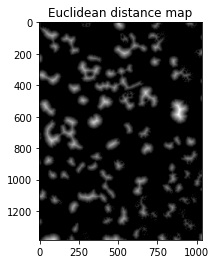

In [5]:
# Calculation of the EDM
edm = ndi.distance_transform_edt(nuc_map)
# Show the resulting map
plt.imshow(edm, cmap='gray')
plt.title("Euclidean distance map")
plt.show()

Using the EDM, the center of each nucleus can be estimated by isolating the pixels of the EDM with the highest values. The problem with this approach is the elliptiv rather then circular nature of nuclei, which will result in mutliple maxima per nucleus. To account for this problem, a pixel is only considered a maximum if it is the only potential maximum in an area around the pixel. If the area is set to roughly match the size of the expected nuclei, we cn assume that only one maximum per nucleus will exist. These potential nuclei centers will then be labeled individually and watershed segmentation will be performed to separate the overlapping nuclei.

Number of detected nuclei: 100


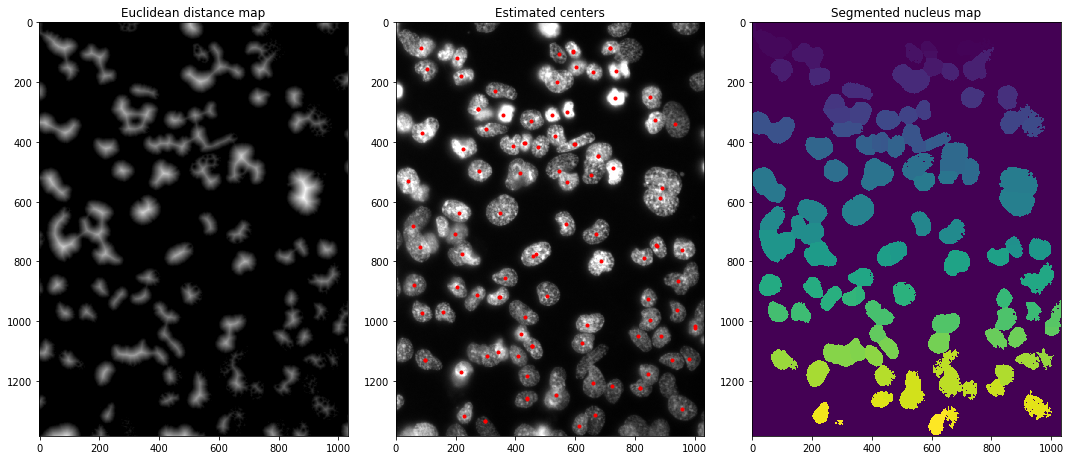

In [6]:
# Determination of the local maxima of the EDM
dist = 25
local_max = peak_local_max(edm, indices=False, min_distance=dist, labels=nuc_map)
# Labelling of the determined maxima with unique IDs
markers, mark_num = ndi.label(local_max)
# Watershed segmentation
watershed = watershed(-edm, markers, mask=nuc_map)
#Show the resulting nucleus map
centers = peak_local_max(edm, min_distance=dist)
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
ax = axes.ravel()
ax[0].imshow(edm, cmap="gray")
ax[0].set_title('Euclidean distance map')
ax[1].imshow(blue, cmap="gray")
ax[1].autoscale(False)
ax[1].plot(centers[:, 1], centers[:, 0], 'r.')
ax[1].set_title('Estimated centers')
ax[2].imshow(watershed)
ax[2].set_title('Segmented nucleus map')
fig.tight_layout()
print("Number of detected nuclei: {}".format(mark_num))
plt.show()

*Note* 
As the observant reader might have noticed, even after watershed segmentation are the nuclei not fully separated. This is a common problem using this approach. This could be solved by implementing sophisticated correction algorithms far beyond the scope of this notebook. Another problem that could occur would be oversegmentation.

---

In the segmented nucleus map, each individually identified nucleus is represented by one color. 

After the segmentation of overlapping nuclei, the intensities of the red and green channel have to be isolated and averaged for each individual nucleus:

In [7]:
# Detection of red signal inside nucleus
red_int = [[]]
red_av_int = []
for y in range(len(img)):
    for x in range(len(img[0])):
        pix = watershed[y][x]
        if pix > 0:
            if len(red_int) >= pix:
                red_int[pix-1].append(red[y][x])
            else:
                red_int.append([red[y][x]])
# Calculation of the average red intensity in the nucleus
for r in range(len(red_int)):
    temp_av = 0
    for i in red_int[r]:
        temp_av += i
    red_av_int.append(temp_av/len(red_int[r]))
# Detection of green signal inside nucleus
green_int = [[]]
green_av_int = []
for y in range(len(img)):
    for x in range(len(img[0])):
        pix = watershed[y][x]
        if pix > 0:
            if len(green_int) >= pix:
                green_int[pix-1].append(green[y][x])
            else:
                green_int.append([green[y][x]])
# Calculation of the average green intensity in the nucleus
for r in range(len(green_int)):
    temp_av = 0
    for i in green_int[r]:
        temp_av += i
    green_av_int.append(temp_av / len(green_int[r]))
                   
# Show the resulting average intensities
red_out = '\n'.join('Nucleus {}: {:.2f}'.format(*k) for k in enumerate(red_av_int, 1))
green_out = '\n'.join('Nucleus {}: {:.2f}'.format(*k) for k in enumerate(green_av_int, 1))
out = "Red average intensities:\n\n{0}\n\nGreen average intensities:\n\n{1}".format(red_out, green_out)
print(out)

Red average intensities:

Nucleus 1: 49.26
Nucleus 2: 72.10
Nucleus 3: 42.98
Nucleus 4: 62.72
Nucleus 5: 47.63
Nucleus 6: 51.69
Nucleus 7: 67.07
Nucleus 8: 53.40
Nucleus 9: 48.94
Nucleus 10: 58.56
Nucleus 11: 40.60
Nucleus 12: 57.43
Nucleus 13: 34.54
Nucleus 14: 41.96
Nucleus 15: 36.82
Nucleus 16: 41.85
Nucleus 17: 61.43
Nucleus 18: 56.52
Nucleus 19: 45.36
Nucleus 20: 49.03
Nucleus 21: 43.44
Nucleus 22: 31.23
Nucleus 23: 23.30
Nucleus 24: 46.48
Nucleus 25: 62.53
Nucleus 26: 32.14
Nucleus 27: 73.08
Nucleus 28: 54.05
Nucleus 29: 28.74
Nucleus 30: 26.42
Nucleus 31: 46.78
Nucleus 32: 39.37
Nucleus 33: 43.26
Nucleus 34: 31.22
Nucleus 35: 33.46
Nucleus 36: 44.64
Nucleus 37: 32.09
Nucleus 38: 23.72
Nucleus 39: 33.58
Nucleus 40: 47.54
Nucleus 41: 33.17
Nucleus 42: 18.83
Nucleus 43: 20.27
Nucleus 44: 35.96
Nucleus 45: 37.13
Nucleus 46: 36.35
Nucleus 47: 34.85
Nucleus 48: 22.58
Nucleus 49: 40.96
Nucleus 50: 36.22
Nucleus 51: 31.78
Nucleus 52: 43.52
Nucleus 53: 24.65
Nucleus 54: 28.55
Nucleus 55: